In [13]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import tensorflow_probability as tfp

In [14]:
np.random.seed(42)

# Parameters for the random walk
num_steps = 5000
initial_temperature = 25  # Initial temperature value
trend_slope = 0.0001  # Small linear upward trend

# Generate random walk with upward trend
random_walk = np.cumsum(np.random.normal(0, 1, num_steps)) + initial_temperature + np.arange(num_steps) * trend_slope
# Generate date range
start_date = datetime.datetime(2000, 1, 1)
date_range = pd.date_range(start=start_date, periods=num_steps, freq='D')

data = {'date': date_range, 'temperature': random_walk}
df = pd.DataFrame(data)
df.head()

,date,temperature
0,2000-01-01,25.496714
1,2000-01-02,25.358550
2,2000-01-03,26.006338
3,2000-01-04,27.529468
4,2000-01-05,27.295415


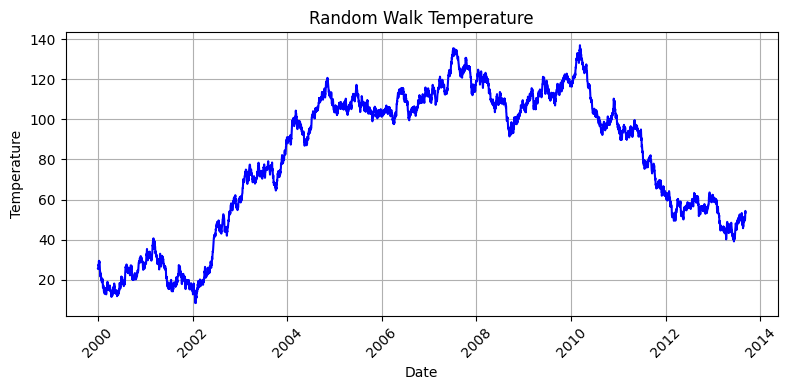

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(df['date'], df['temperature'], linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Random Walk Temperature')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# x1 = np.array(df.iloc[:,1]+np.random.randn(df.shape[0])).astype(np.float32).reshape(-1,1)
train_size = int(0.8 * num_steps)

# x1 = np.array(df.iloc[:train_size,1]).astype(np.float32).reshape(-1,1)
sequence_length = 10
train_input = np.lib.stride_tricks.sliding_window_view(df.iloc[:train_size,1].values, sequence_length)
val_input = np.lib.stride_tricks.sliding_window_view(df.iloc[train_size:,1].values, sequence_length)

y1 = np.array(df.iloc[sequence_length:train_size+1,1]).T.astype(np.float32).reshape(-1,1)
y2 = np.array(df.iloc[sequence_length+train_size-1:,1]).T.astype(np.float32).reshape(-1,1)

tfd = tfp.distributions

In [17]:
print(val_input.shape)
print(y2.shape)
print(train_input[:5])
print()
print(y1[:5])
print(train_input.shape,y1.shape)

(991, 10)
(991, 1)
[[25.49671415 25.35854985 26.00633839 27.52946825 27.29541487 27.06137791
  28.64069073 29.40822546 28.93885107 29.48151112]
 [25.35854985 26.00633839 27.52946825 27.29541487 27.06137791 28.64069073
  29.40822546 28.93885107 29.48151112 29.01819342]
 [26.00633839 27.52946825 27.29541487 27.06137791 28.64069073 29.40822546
  28.93885107 29.48151112 29.01819342 28.55256367]
 [27.52946825 27.29541487 27.06137791 28.64069073 29.40822546 28.93885107
  29.48151112 29.01819342 28.55256367 28.79462594]
 [27.29541487 27.06137791 28.64069073 29.40822546 28.93885107 29.48151112
  29.01819342 28.55256367 28.79462594 26.8814457 ]]

[[29.018194]
 [28.552565]
 [28.794626]
 [26.881445]
 [25.156628]]
(3991, 10) (3991, 1)


In [18]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])


In [19]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(32,activation='relu'),
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/train_input.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

In [20]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Do inference.
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.01), loss=negloglik)
model.fit(train_input, y1, epochs=1500, verbose=1);


Epoch 1/1500


125/125 [==============================] - 0s 562us/step - loss: 606179.4375
Epoch 2/1500
125/125 [==============================] - 0s 460us/step - loss: 14967.2939
Epoch 3/1500
125/125 [==============================] - 0s 469us/step - loss: 13363.6514
Epoch 4/1500
125/125 [==============================] - 0s 482us/step - loss: 9136.7061
Epoch 5/1500
125/125 [==============================] - 0s 545us/step - loss: 7444.9175
Epoch 6/1500
125/125 [==============================] - 0s 510us/step - loss: 8441.6172
Epoch 7/1500
125/125 [==============================] - 0s 456us/step - loss: 7464.1250
Epoch 8/1500
125/125 [==============================] - 0s 463us/step - loss: 7370.9702
Epoch 9/1500
125/125 [==============================] - 0s 460us/step - loss: 8896.4355
Epoch 10/1500
125/125 [==============================] - 0s 505us/step - loss: 7379.1533
Epoch 11/1500
125/125 [==============================] - 0s 463us/step - loss: 7477.5649
Epoch 12/1500
125/125 [================

In [21]:
# Profit.
yhat = model(val_input)
[print(np.squeeze(w.numpy())) for w in model.weights];
assert isinstance(yhat, tfd.Distribution)

[[ 0.18001941 -0.27129304 -0.04984814 -0.24794069 -0.04966971  0.01200509
  -0.02456248  0.22369793 -0.04635486 -0.3297585   0.21189107  0.00593973
  -0.28154004 -0.11520823  0.299423   -0.47466365  0.07797403 -0.23211758
  -0.07110336  0.01648732 -0.20145367  0.06172214  0.15350096 -0.0237937
  -0.32396144 -0.2712971   0.08492294 -0.06446052  0.00642917 -0.272466
  -0.12197724  0.34978172]
 [-0.33732623 -0.08741568  0.37607458 -0.2306174  -0.37564883 -0.25531253
  -0.36003137 -0.34863776 -0.29338765 -0.32632035  0.27286035  0.15373082
  -0.36807206 -0.03991902  0.23582622 -0.4845065  -0.03403008  0.12410713
   0.35068944 -0.02685151  0.155261    0.18447118 -0.08360434  0.06190936
   0.18579584 -0.2852211  -0.23451978 -0.07511142 -0.07754287 -0.26843604
   0.01027215 -0.10907379]
 [ 0.0382278  -0.42361355 -0.31559655 -0.21888828  0.04271778  0.29427555
   0.30893835 -0.11913553 -0.06230086  0.08832939 -0.22019984 -0.04534721
  -0.2006642  -0.02291205 -0.32007575  0.15715113  0.09877835

In [22]:
yhats = [model(val_input) for _ in range(100)]
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())

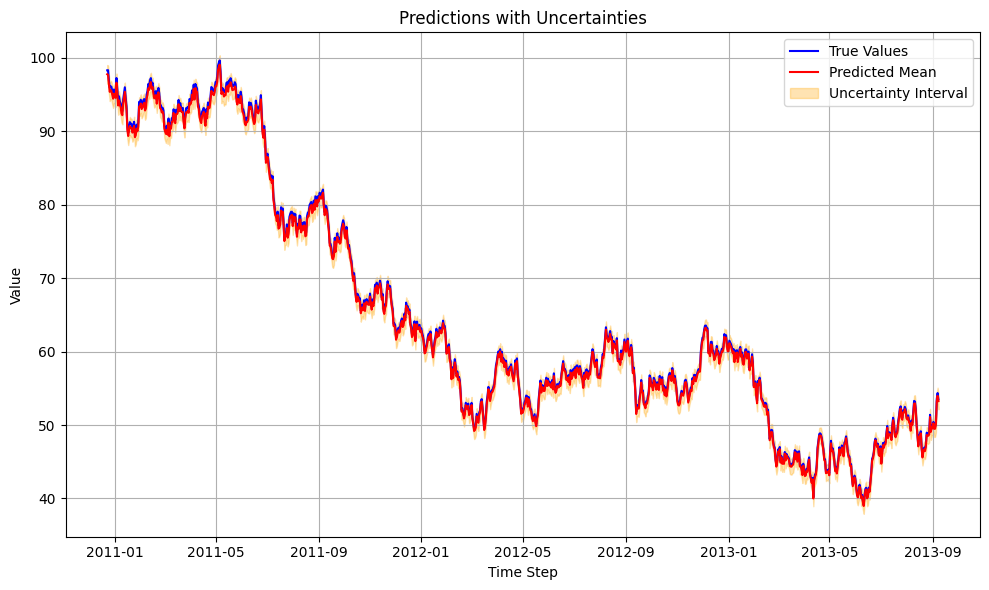

In [23]:
val_dates = np.array(df.iloc[sequence_length+train_size-1:,0]).T.reshape(-1,1)

upper_bound = m + s
lower_bound = m - s

plt.figure(figsize=(10, 6))
plt.plot(val_dates,y2, label='True Values', color='blue')
plt.plot(val_dates,m, label='Predicted Mean', color='red')
plt.fill_between(val_dates.reshape(-1), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions with Uncertainties')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(41, 10) (41, 1) (41, 1) (41,)


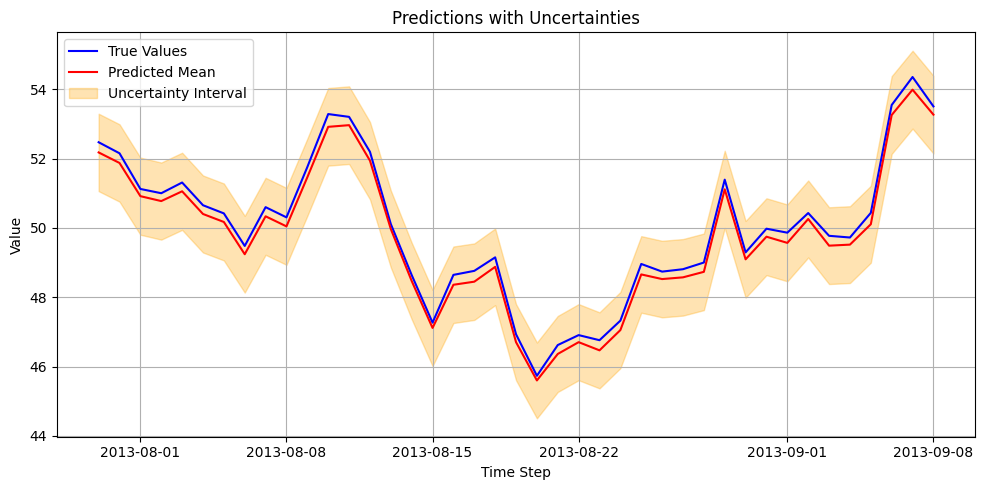

In [24]:
test_size = -50
test_input = np.lib.stride_tricks.sliding_window_view(df.iloc[test_size:,1].values, sequence_length)
y3 = np.array(df.iloc[sequence_length+test_size-1:,1]).T.astype(np.float32).reshape(-1,1)
test_dates = np.array(df.iloc[sequence_length+test_size-1:,0]).T.reshape(-1,1)

yhats_test = [model(test_input) for _ in range(100)]

for i, yhat in enumerate(yhats_test):
  m_test = np.squeeze(yhat.mean())
  s_test = np.squeeze(yhat.stddev())

print(test_input.shape,y3.shape,test_dates.shape,m_test.shape)
upper_bound = m_test + s_test
lower_bound = m_test - s_test

plt.figure(figsize=(10,5))
plt.plot(test_dates, y3, label='True Values', color='blue')
plt.plot(test_dates, m_test, label='Predicted Mean', color='red')
plt.fill_between(test_dates.reshape(-1), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions with Uncertainties')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
#maybe log the close before normalise
def prepare_rnn_data(df, window_size, train_ratio=0.8):
    # Extract temperature values
    temperature_values = df['temperature'].values.reshape(-1, 1)

    # Split data into training and validation sets
    train_size = int(len(temperature_values) * train_ratio)
    train_data = temperature_values[:train_size]
    val_data = temperature_values[train_size:]

    # Normalize the training data using Min-Max scaling
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)

    # Create sequences of input data and corresponding targets for training
    train_input_sequences = []
    train_targets = []
    for i in range(len(train_data) - window_size):
        input_seq = train_data[i : i + window_size]
        target = train_data[i + window_size]
        train_input_sequences.append(input_seq)
        train_targets.append(target)

    # Normalize the validation data using the trained scaler
    val_data = scaler.transform(val_data)
    # Create sequences of input data and corresponding targets for validation
    val_input_sequences = []
    val_targets = []
    for i in range(len(val_data) - window_size):
        input_seq = val_data[i : i + window_size]
        target = val_data[i + window_size]
        val_input_sequences.append(input_seq)
        val_targets.append(target)

    return (
        np.array(train_input_sequences),
        np.array(train_targets),
        np.array(val_input_sequences),
        np.array(val_targets),
        scaler,
    )

In [5]:
window_size = 10
train_ratio = 0.8
train_input, train_target, val_input, val_target, scaler = prepare_rnn_data(df, window_size,train_ratio)

print("Train Input Shape:", train_input.shape)
print("Train Target Shape:", train_target.shape)
print("Validation Input Shape:", val_input.shape)
print("Validation Target Shape:", val_target.shape)

Train Input Shape: (1590, 10, 1)
Train Target Shape: (1590, 1)
Validation Input Shape: (390, 10, 1)
Validation Target Shape: (390, 1)


In [38]:

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
        tfp.distributions.Normal(loc=t, scale=1),
        reinterpreted_batch_ndims=1)),
    ])
    
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(2 * n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
        tfp.distributions.Normal(
            loc=t[..., :n],
            scale=1e-5 + tf.nn.softplus(c + t[..., n:])
        ),
    reinterpreted_batch_ndims=1)),
    ])

In [39]:
def create_rnn_model(input_shape, rnn_units, dense_units):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(rnn_units, input_shape=input_shape, activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(rnn_units, activation='relu'),
        tf.keras.layers.Dense(dense_units),
        tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))
    ])
    return model


In [40]:
rnn_units = 32  # Number of RNN units
dense_units = 8  # Number of units in the dense layer (output)

# Create the RNN model
input_shape = (window_size, 1)  # Shape of input sequences (window size, number of features)
model = create_rnn_model(input_shape, rnn_units, dense_units)

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Compile the model
model.compile(optimizer='adam', loss=negloglik)

# Train the model
batch_size = 32
epochs = 50
history = model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_input, val_target))

Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 2.0342 - val_loss: 2.7465
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 1.5782 - val_loss: 2.5340
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 1.7807 - val_loss: 3.9327
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 1.6446 - val_loss: 1.5309
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 1.9941 - val_loss: 2.4175
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 1.4769 - val_loss: 2.0659
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 1.6353 - val_loss: 1.9262
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 1.9667 - val_loss: 3.9466
Epoch 9/50
50/50 [==============================] - 0s 2ms/step - loss: 1.3178 - val_loss: 2.3718
Epoch 10/50
50/50 [==============================] - 0s 2ms/step - loss: 1.4195 - val_loss: 3.2098
Epoch 11/50
50/50 [

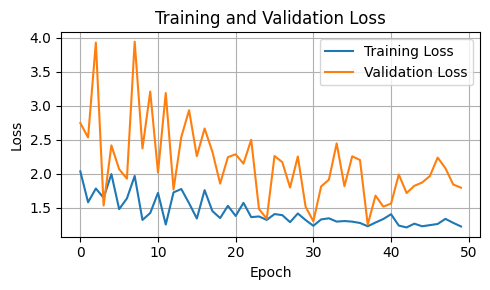

In [41]:

plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


13/13 [==============================] - 0s 1ms/step


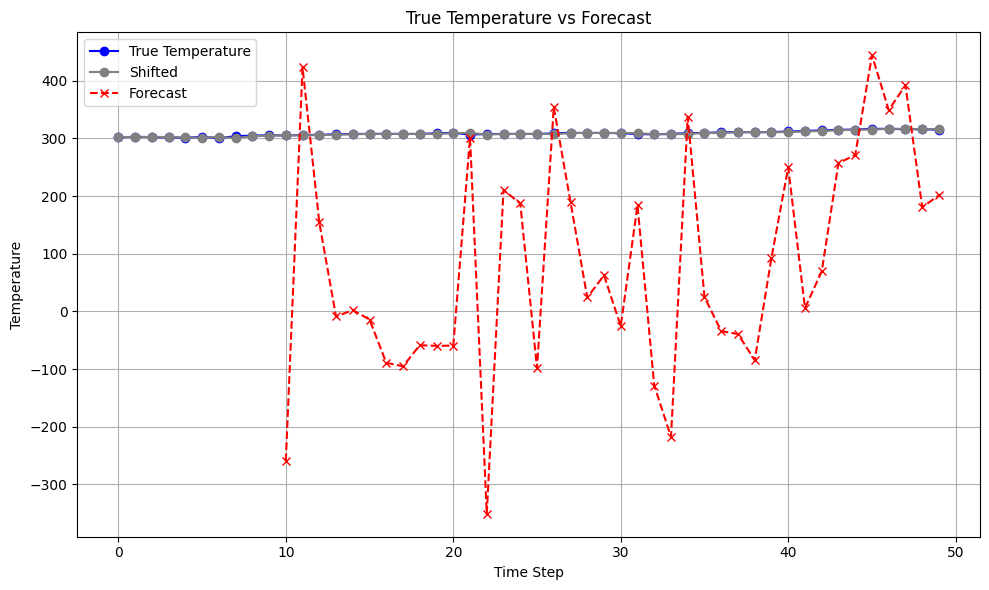

In [42]:
train_size = int(len(df['temperature']) * train_ratio)
train_size = -50
true_values = df['temperature'].values[train_size:]
true_values2 = df['temperature'].shift(1).values[train_size:]
# Assuming 'model' is your trained RNN model
forecast_input = val_input  # You can replace this with your test/validation data
forecast = model.predict(forecast_input)

# Inverse transform forecast data using the scaler to get original temperature scale
forecast = scaler.inverse_transform(forecast)[train_size+10:]

plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Temperature', marker='o', linestyle='-', color='b')
plt.plot(true_values2, label='Shifted', marker='o', linestyle='-', color='grey')
plt.plot(range(window_size, len(true_values)), forecast, label='Forecast', marker='x', linestyle='--', color='r')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('True Temperature vs Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def calculate_mape(true_data, forecast_data):
    absolute_percentage_errors = np.abs((true_data - forecast_data) / true_data)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

def calculate_rmse(true_data, forecast_data):
    rmse = np.sqrt(mean_squared_error(true_data, forecast_data))
    return rmse

def calculate_mae(true_data, forecast_data):
    mae = mean_absolute_error(true_data, forecast_data)
    return mae

def calculate_r2(true_data, forecast_data):
    r2 = r2_score(true_data, forecast_data)
    return r2

def calculate_forecast_bias(true_data, forecast_data):
    forecast_bias = np.mean(forecast_data - true_data)
    return forecast_bias

true_values = df['temperature'].values[train_size+window_size:]
true_values2 = df['temperature'].shift(1).values[train_size+window_size:]
    
mape = calculate_mape(true_values, forecast)
rmse = calculate_rmse(true_values, forecast)
mae = calculate_mae(true_values, forecast)
fb = calculate_forecast_bias(true_values, forecast)
r2 = calculate_r2(true_values, forecast)
print("MAPE:", mape,'\nRMSE:',rmse,'\nMAE:',mae,'\nFB:',fb,'\nR2:',r2)
print()
mape2 = calculate_mape(true_values, true_values2)
rmse2 = calculate_rmse(true_values, true_values2)
mae2 = calculate_mae(true_values, true_values2)
r22 = calculate_r2(true_values, true_values2)
fb2 = calculate_forecast_bias(true_values, true_values2)
print("MAPE:", mape,'\nRMSE:',rmse,'\nMAE:',mae,'\nFB:',fb2,'\nR2:',r2)

MAPE: 1.1595738047611144 
RMSE: 1.9240160372801816 
MAE: 1.7293224200545894 
FB: -1.625459616721389 
R2: 0.6393624615599169

MAPE: 1.1595738047611144 
RMSE: 1.9240160372801816 
MAE: 1.7293224200545894 
FB: -0.2468575709205254 
R2: 0.6393624615599169
